In [ ]:
!pip install  ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import plotly
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly,plot_cross_validation_metric
from prophet.diagnostics import performance_metrics,cross_validation

In [ ]:
# Load the stock price data
data = pd.read_csv('HDFC.csv')

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [ ]:
data

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
1,2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2,2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
3,2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
4,2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
5302,2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
5303,2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327
5304,2021-04-29,HDFC,EQ,2577.00,2590.90,2628.00,2533.00,2539.70,2538.85,2569.65,3005468,7.722995e+14,132826.0,1472924.0,0.4901


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

In [ ]:
data.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,1283.666114,1284.393074,1304.269732,1263.297842,1283.885017,1284.071005,1283.664578,1.848187e+06,2.620759e+14,102159.051303,1.329440e+06,0.653088
std,709.395090,709.703665,721.308080,697.450309,709.250204,709.430515,709.109622,2.991387e+06,3.607844e+14,57948.603200,2.555073e+06,0.128115
min,271.750000,284.000000,290.500000,273.250000,282.850000,283.850000,283.600000,2.919000e+03,1.834686e+11,973.000000,1.786000e+03,0.119000
25%,668.650000,669.712500,677.512500,660.000000,669.000000,668.662500,668.265000,3.034970e+05,2.461178e+13,62011.500000,2.688070e+05,0.575200
50%,1136.275000,1135.400000,1156.725000,1119.000000,1135.000000,1136.675000,1136.720000,1.337788e+06,1.684207e+14,90405.000000,1.021574e+06,0.666900
75%,1811.475000,1813.812500,1835.000000,1783.075000,1812.000000,1811.787500,1811.680000,2.732310e+06,3.419282e+14,129754.500000,1.939101e+06,0.742000
max,3180.150000,3148.000000,3262.000000,3100.550000,3178.000000,3180.150000,3166.580000,1.584141e+08,1.043773e+16,538170.000000,1.483131e+08,0.989400


In [ ]:
data.isnull().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

In [ ]:
data[['Date','Close']]

,Date,Close
0,2000-01-03,293.50
1,2000-01-04,304.05
2,2000-01-05,292.80
3,2000-01-06,296.45
4,2000-01-07,286.55
...,...,...
5301,2021-04-26,2509.80
5302,2021-04-27,2518.40
5303,2021-04-28,2577.00
5304,2021-04-29,2538.85


In [ ]:
data[['Date','Close']].describe()

,Close
count,5306.000000
mean,1284.071005
std,709.430515
min,283.850000
25%,668.662500
50%,1136.675000
75%,1811.787500
max,3180.150000


<Axes: xlabel='Date'>

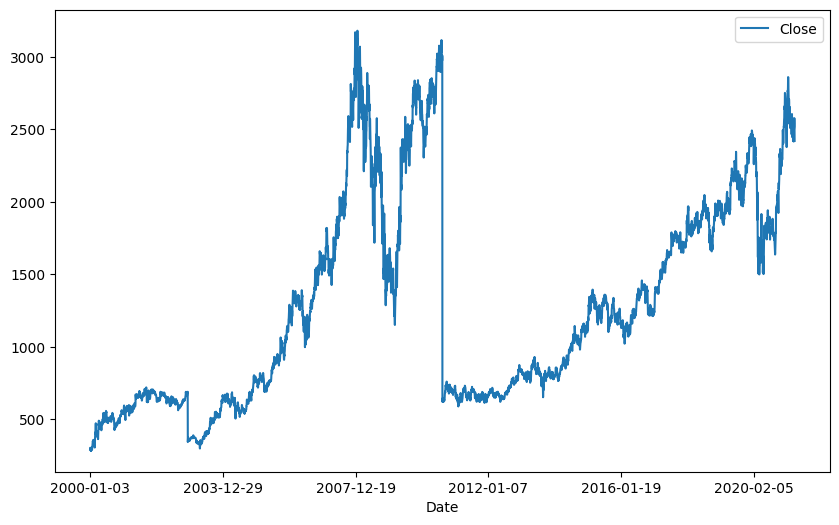

In [ ]:
data.plot(x='Date',y='Close', figsize=(10,6))

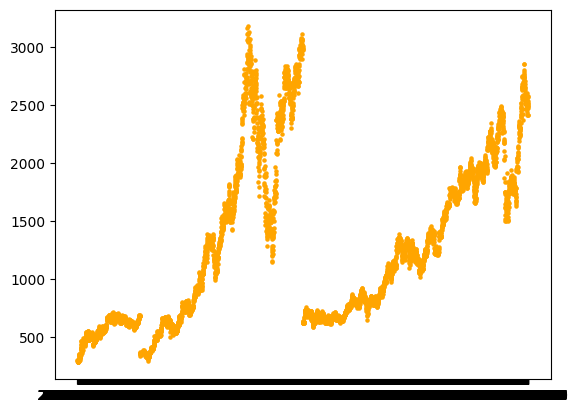

In [ ]:
plt.scatter(x=data['Date'],y=data['Close'],c='orange', s=5)

<ipython-input-60-b47abbd9b1aa>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



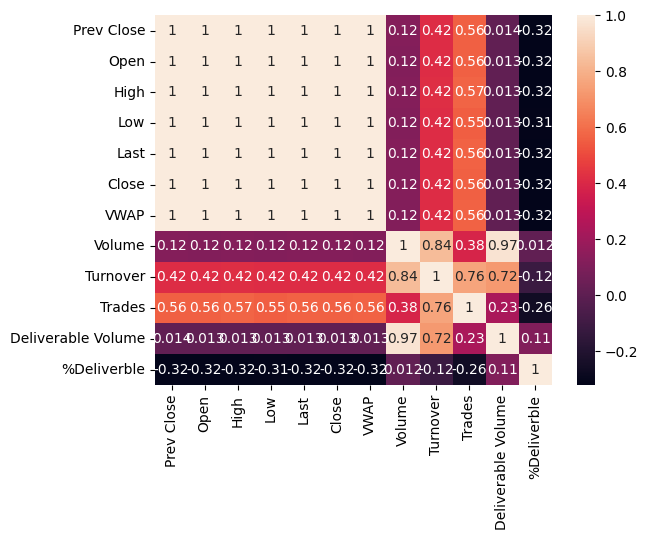

In [ ]:
dataplot= sns.heatmap(data.corr(),annot=True)

In [ ]:
# Split the data into training and testing datasets
X = scaled_data[:-1]  # Input sequence
y = scaled_data[1:]   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [ ]:
X

array([[0.00333184],
       [0.00697442],
       [0.00309015],
       ...,
       [0.77151883],
       [0.79175155],
       [0.77857957]])

In [ ]:
y

array([[0.00697442],
       [0.00309015],
       [0.00435038],
       ...,
       [0.79175155],
       [0.77857957],
       [0.73757898]])

In [ ]:
# Reshape the data for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
117/117 [==============================] - 5s 6ms/step - loss: 0.0449
Epoch 2/10
117/117 [==============================] - 1s 5ms/step - loss: 7.5452e-04
Epoch 3/10
117/117 [==============================] - 1s 5ms/step - loss: 5.6382e-04
Epoch 4/10
117/117 [==============================] - 1s 5ms/step - loss: 5.2495e-04
Epoch 5/10
117/117 [==============================] - 1s 7ms/step - loss: 4.7397e-04
Epoch 6/10
117/117 [==============================] - 1s 7ms/step - loss: 4.4040e-04
Epoch 7/10
117/117 [==============================] - 1s 10ms/step - loss: 4.0884e-04
Epoch 8/10
117/117 [==============================] - 1s 10ms/step - loss: 3.8822e-04
Epoch 9/10
117/117 [==============================] - 1s 9ms/step - loss: 3.9489e-04
Epoch 10/10
117/117 [==============================] - 1s 9ms/step - loss: 3.7740e-04


In [ ]:
from statsmodels.tools.eval_measures import rmse

50/50 [==============================] - 2s 4ms/step
R2 Score: 0.9928972296006539


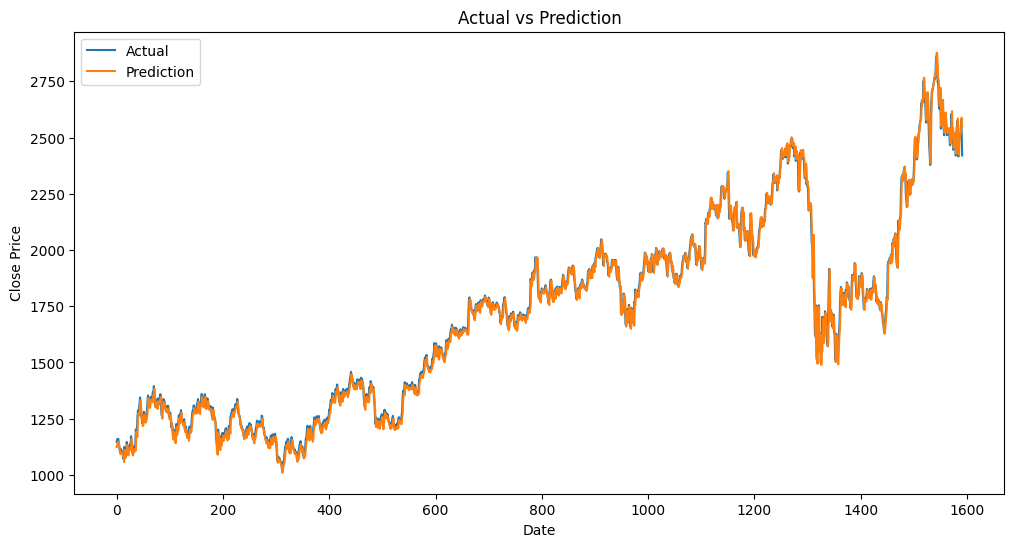

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Scale the predictions back to the original range
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Calculate R2 score
r2 = r2_score(y_test, predictions)
print("R2 Score:", r2)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()


In [ ]:
print("Root Mean Squred Error between actual and predicted values: ",rmse(predictions,y_test))
print("Mean Value of Test Dataset: ", y_test.mean())

Root Mean Squred Error between actual and predicted values:  [35.42093704]
Mean Value of Test Dataset:  1708.694849246231


In [ ]:
predictions

array([[1123.9048],
       [1133.6469],
       [1145.6421],
       ...,
       [2528.0242],
       [2587.9167],
       [2548.9285]], dtype=float32)

In [ ]:
data

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
1,2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2,2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
3,2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
4,2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
5302,2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
5303,2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327
5304,2021-04-29,HDFC,EQ,2577.00,2590.90,2628.00,2533.00,2539.70,2538.85,2569.65,3005468,7.722995e+14,132826.0,1472924.0,0.4901


In [ ]:
data['Date']=pd.to_datetime(data['Date'])
train_size = int(len(data)-365)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
prophet_data = data[['Date','Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
# Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data[:train_size])

# Make predictions with the Prophet model
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)
'''prophet_predictions = prophet_predictions['yhat'].tail(len(test_data)).values'''

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/gwc6lv_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/l3zlwq_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82282', 'data', 'file=/tmp/tmpdw4yusk7/gwc6lv_o.json', 'init=/tmp/tmpdw4yusk7/l3zlwq_z.json', 'output', 'file=/tmp/tmpdw4yusk7/prophet_model24ti7rgp/prophet_model-20230614223925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


"prophet_predictions = prophet_predictions['yhat'].tail(len(test_data)).values"

In [ ]:
df_cv = cross_validation(prophet_model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:prophet:Making 35 forecasts with cutoffs between 2002-02-10 00:00:00 and 2018-11-13 00:00:00


  0%|          | 0/35 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/bwhyzoh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/acuixw36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51600', 'data', 'file=/tmp/tmpdw4yusk7/bwhyzoh5.json', 'init=/tmp/tmpdw4yusk7/acuixw36.json', 'output', 'file=/tmp/tmpdw4yusk7/prophet_model94u_2xd2/prophet_model-20230614223940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/cxves6bj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdw4yusk7/uh2x9eke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-02-11,646.435403,622.517454,671.032330,635.95,2002-02-10
1,2002-02-12,646.650723,621.772864,670.771136,643.50,2002-02-10
2,2002-02-13,645.748603,620.834863,669.889776,650.95,2002-02-10
3,2002-02-14,647.247068,623.354363,672.585693,690.30,2002-02-10
4,2002-02-15,647.944469,623.329575,672.214285,668.40,2002-02-10


In [ ]:
df_cv2=performance_metrics(df_cv)
df_cv2

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,148093.198758,384.828791,250.917779,0.245839,0.106257,0.267879,0.506665
1,37 days,149707.880248,386.921026,251.633118,0.247053,0.105619,0.268505,0.505679
2,38 days,150713.098540,388.217849,252.601238,0.248400,0.105476,0.271269,0.503337
3,39 days,151281.405390,388.949104,253.275370,0.249736,0.105619,0.272683,0.501026
4,40 days,152288.137502,390.241127,254.104633,0.251217,0.106146,0.274170,0.498412
...,...,...,...,...,...,...,...,...
325,361 days,651151.459760,806.939564,530.686378,0.557660,0.176692,0.494292,0.557489
326,362 days,648919.615418,805.555470,529.627775,0.556043,0.176032,0.492901,0.561059
327,363 days,649405.111359,805.856756,530.963800,0.555333,0.175278,0.493066,0.562348
328,364 days,650667.728903,806.639776,531.996838,0.556423,0.177541,0.494390,0.561979


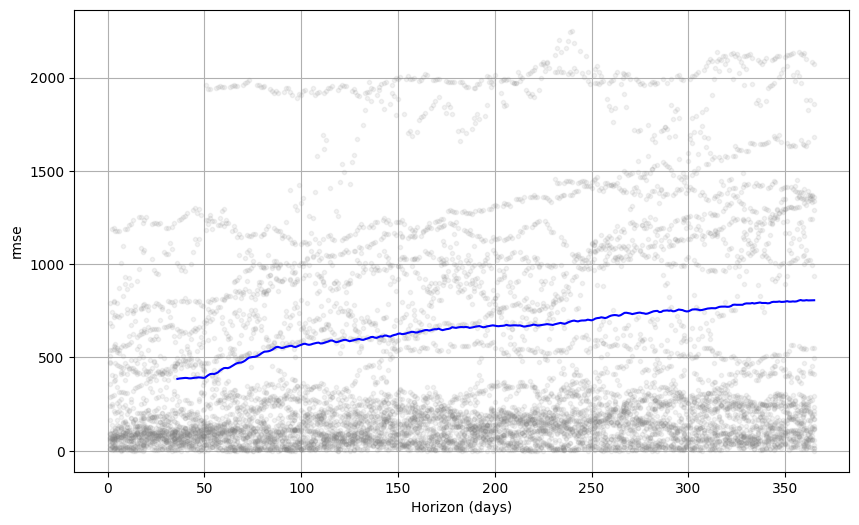

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig.show()


In [ ]:
forecast.tail

<bound method NDFrame.tail of              ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2000-01-03   421.249029   133.987422   670.495352   421.249029   
1    2000-01-04   421.556773   137.808218   677.536303   421.556773   
2    2000-01-05   421.864518   142.356330   703.252332   421.864518   
3    2000-01-06   422.172262   132.375685   663.175466   422.172262   
4    2000-01-07   422.480006   147.968648   666.718961   422.480006   
...         ...          ...          ...          ...          ...   
5301 2020-11-08  2384.428725  1915.959902  2702.491475  2090.039308   
5302 2020-11-09  2385.080760  1978.391707  2791.233074  2089.403588   
5303 2020-11-10  2385.732795  2019.229505  2786.078216  2088.767869   
5304 2020-11-11  2386.384830  1981.697956  2797.911135  2089.049039   
5305 2020-11-12  2387.036865  1959.698654  2803.939428  2087.961455   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      421.249029       -7.626512   

In [ ]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5301,2020-11-08,2289.485640,1915.959902,2702.491475
5302,2020-11-09,2380.899372,1978.391707,2791.233074
5303,2020-11-10,2382.591569,2019.229505,2786.078216
5304,2020-11-11,2381.986893,1981.697956,2797.911135
5305,2020-11-12,2384.268514,1959.698654,2803.939428


In [ ]:
test_data

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
4941,2019-11-14,HDFC,EQ,2207.45,2207.90,2232.85,2190.20,2222.80,2226.80,2213.80,1953996,4.325755e+14,90409.0,936405.0,0.4792
4942,2019-11-15,HDFC,EQ,2226.80,2220.10,2238.75,2208.00,2226.00,2224.05,2222.09,3346325,7.435844e+14,122637.0,2147793.0,0.6418
4943,2019-11-18,HDFC,EQ,2224.05,2222.50,2240.85,2210.00,2239.00,2236.30,2225.34,2249585,5.006103e+14,116995.0,1428235.0,0.6349
4944,2019-11-19,HDFC,EQ,2236.30,2235.60,2238.75,2202.20,2215.70,2212.10,2218.28,2916866,6.470424e+14,162909.0,1952597.0,0.6694
4945,2019-11-20,HDFC,EQ,2212.10,2215.00,2221.00,2193.75,2196.00,2200.95,2207.67,1772677,3.913487e+14,124852.0,1045668.0,0.5899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
5302,2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
5303,2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327
5304,2021-04-29,HDFC,EQ,2577.00,2590.90,2628.00,2533.00,2539.70,2538.85,2569.65,3005468,7.722995e+14,132826.0,1472924.0,0.4901


In [ ]:
fig = plot_plotly(prophet_model,forecast)
fig.show()

In [ ]:
fig = plot_components_plotly(prophet_model,forecast)
fig.show()

#**EVALUATING MODEL**

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
predictions_prophet=forecast.iloc[-365:]['yhat']

In [ ]:
print("Root Mean Squred Error between actual and predicted values: ",rmse(predictions_prophet,test_data['Close']))
print("Mean Value of Test Dataset: ", test_data['Close'].mean())

Root Mean Squred Error between actual and predicted values:  367.6802323456102
Mean Value of Test Dataset:  2147.451506849315


In [ ]:
data

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
1,2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2,2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
3,2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
4,2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
5302,2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
5303,2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327
5304,2021-04-29,HDFC,EQ,2577.00,2590.90,2628.00,2533.00,2539.70,2538.85,2569.65,3005468,7.722995e+14,132826.0,1472924.0,0.4901


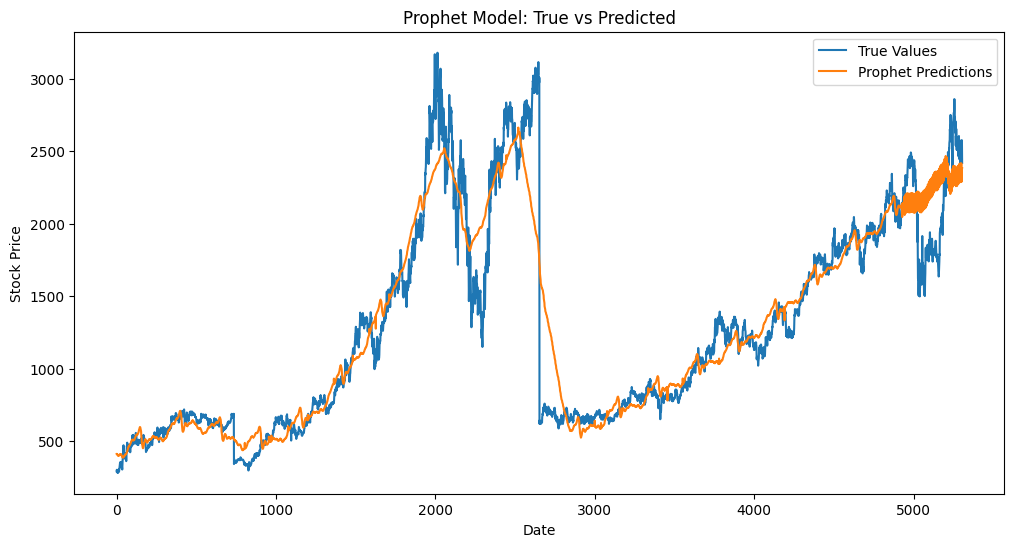

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='True Values')
plt.plot(forecast['yhat'],label='Prophet Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Prophet Model: True vs Predicted')
plt.legend()
plt.show()

In [ ]:
!pip install pmdarima''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pmdarima import auto_arima

# Load the stock price data
data = pd.read_csv('HDFC.csv')

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Perform AutoARIMA for time series forecasting
model = auto_arima(data['Close'], trace=True, suppress_warnings=True)

# Make predictions
predictions = model.predict(n_periods=len(data))

# Calculate R2 score
r2 = r2_score(data['Close'], predictions)
print("R2 Score:", r2)

# Plot actual vs prediction
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual')
plt.plot(data.index, predictions, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()'''


'import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import r2_score\nfrom pmdarima import auto_arima\n\n# Load the stock price data\ndata = pd.read_csv(\'HDFC.csv\')\n\n# Preprocess the data\ndata[\'Date\'] = pd.to_datetime(data[\'Date\'])\ndata.set_index(\'Date\', inplace=True)\ndata.sort_index(inplace=True)\n\n# Perform AutoARIMA for time series forecasting\nmodel = auto_arima(data[\'Close\'], trace=True, suppress_warnings=True)\n\n# Make predictions\npredictions = model.predict(n_periods=len(data))\n\n# Calculate R2 score\nr2 = r2_score(data[\'Close\'], predictions)\nprint("R2 Score:", r2)\n\n# Plot actual vs prediction\nplt.figure(figsize=(12, 6))\nplt.plot(data.index, data[\'Close\'], label=\'Actual\')\nplt.plot(data.index, predictions, label=\'Prediction\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Close Price\')\nplt.title(\'Actual vs Prediction\')\nplt.legend()\nplt.show()'